## **Installing & Importing the necessary libraries**

In [1]:
#!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## **Importing Bitcoin data in INR from Yahoo Finance.**

In [3]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Bitcoin in INR
ticker = 'BTC-INR'

# Fetch the data
bitcoin_data = yf.download(ticker, period='max')

# Flatten the MultiIndex if necessary and clean column names
if isinstance(bitcoin_data.columns, pd.MultiIndex):
    bitcoin_data.columns = [' '.join(col).strip() for col in bitcoin_data.columns]

# Remove "BTC-INR" from column names
bitcoin_data.columns = [col.replace('BTC-INR', '').strip() for col in bitcoin_data.columns]

# Convert numerical values to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

bitcoin_data

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-09-17 00:00:00+00:00,27851.64,27851.64,28542.23,27552.50,28443.33,1282359120
2014-09-18 00:00:00+00:00,25774.12,25774.12,27822.77,25085.74,27822.77,2093992320
2014-09-19 00:00:00+00:00,24023.34,24023.34,25988.84,23366.09,25753.65,2307413745
2014-09-20 00:00:00+00:00,24881.81,24881.81,25757.56,23724.38,24015.85,2243150060
2014-09-21 00:00:00+00:00,24268.26,24268.26,25096.12,23925.06,24831.97,1617399085
...,...,...,...,...,...,...
2024-10-22 00:00:00+00:00,5663915.00,5663915.00,5839700.50,5618863.00,5800961.00,3152675161183
2024-10-23 00:00:00+00:00,5664384.00,5664384.00,5702272.00,5598557.00,5663314.00,2674757313294
2024-10-24 00:00:00+00:00,5584820.00,5584820.00,5667860.50,5481124.50,5664466.00,2712367203360


In [4]:
bitcoin_data.reset_index(inplace = True)
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date']).dt.date
bitcoin_data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,27851.64,27851.64,28542.23,27552.50,28443.33,1282359120
1,2014-09-18,25774.12,25774.12,27822.77,25085.74,27822.77,2093992320
2,2014-09-19,24023.34,24023.34,25988.84,23366.09,25753.65,2307413745
3,2014-09-20,24881.81,24881.81,25757.56,23724.38,24015.85,2243150060
4,2014-09-21,24268.26,24268.26,25096.12,23925.06,24831.97,1617399085
...,...,...,...,...,...,...,...
3688,2024-10-22,5663915.00,5663915.00,5839700.50,5618863.00,5800961.00,3152675161183
3689,2024-10-23,5664384.00,5664384.00,5702272.00,5598557.00,5663314.00,2674757313294
3690,2024-10-24,5584820.00,5584820.00,5667860.50,5481124.50,5664466.00,2712367203360
3691,2024-10-25,5731121.00,5731121.00,5786113.00,5586906.00,5603441.50,2641389528821


## **Exploratory Data Analysis (EDA)**

In [5]:
bitcoin_data.shape

(3693, 7)

In [6]:
bitcoin_data.isna().sum()

,0
Date,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [7]:
bitcoin_data.describe()

,Adj Close,Close,High,Low,Open,Volume
count,3693.00,3693.00,3693.00,3693.00,3693.00,3693.00
mean,1423702.55,1423702.55,1453711.75,1389236.51,1422269.42,1353242761498.12
std,1615469.36,1615469.36,1648546.48,1577756.39,1614194.14,1460138190919.90
min,11058.42,11058.42,13098.74,10649.06,10983.54,362858870.00
25%,77635.27,77635.27,78462.91,75484.75,77135.26,21218106640.00
50%,658001.06,658001.06,673642.00,643129.31,657603.62,1082092714760.00
75%,2387702.00,2387702.00,2427985.00,2322612.50,2388344.50,2234954211952.00
max,6053744.50,6053744.50,6111938.00,5908992.00,6053402.50,25829977008274.00


In [8]:
bitcoin_data.duplicated().sum()

0

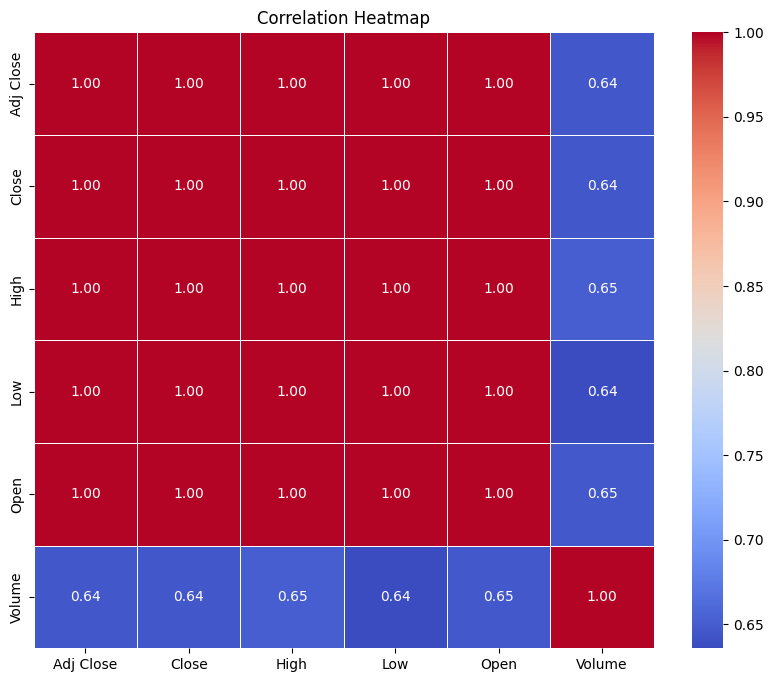

In [9]:
# Select numerical columns
numerical_df = bitcoin_data.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numerical_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### **Histogram**

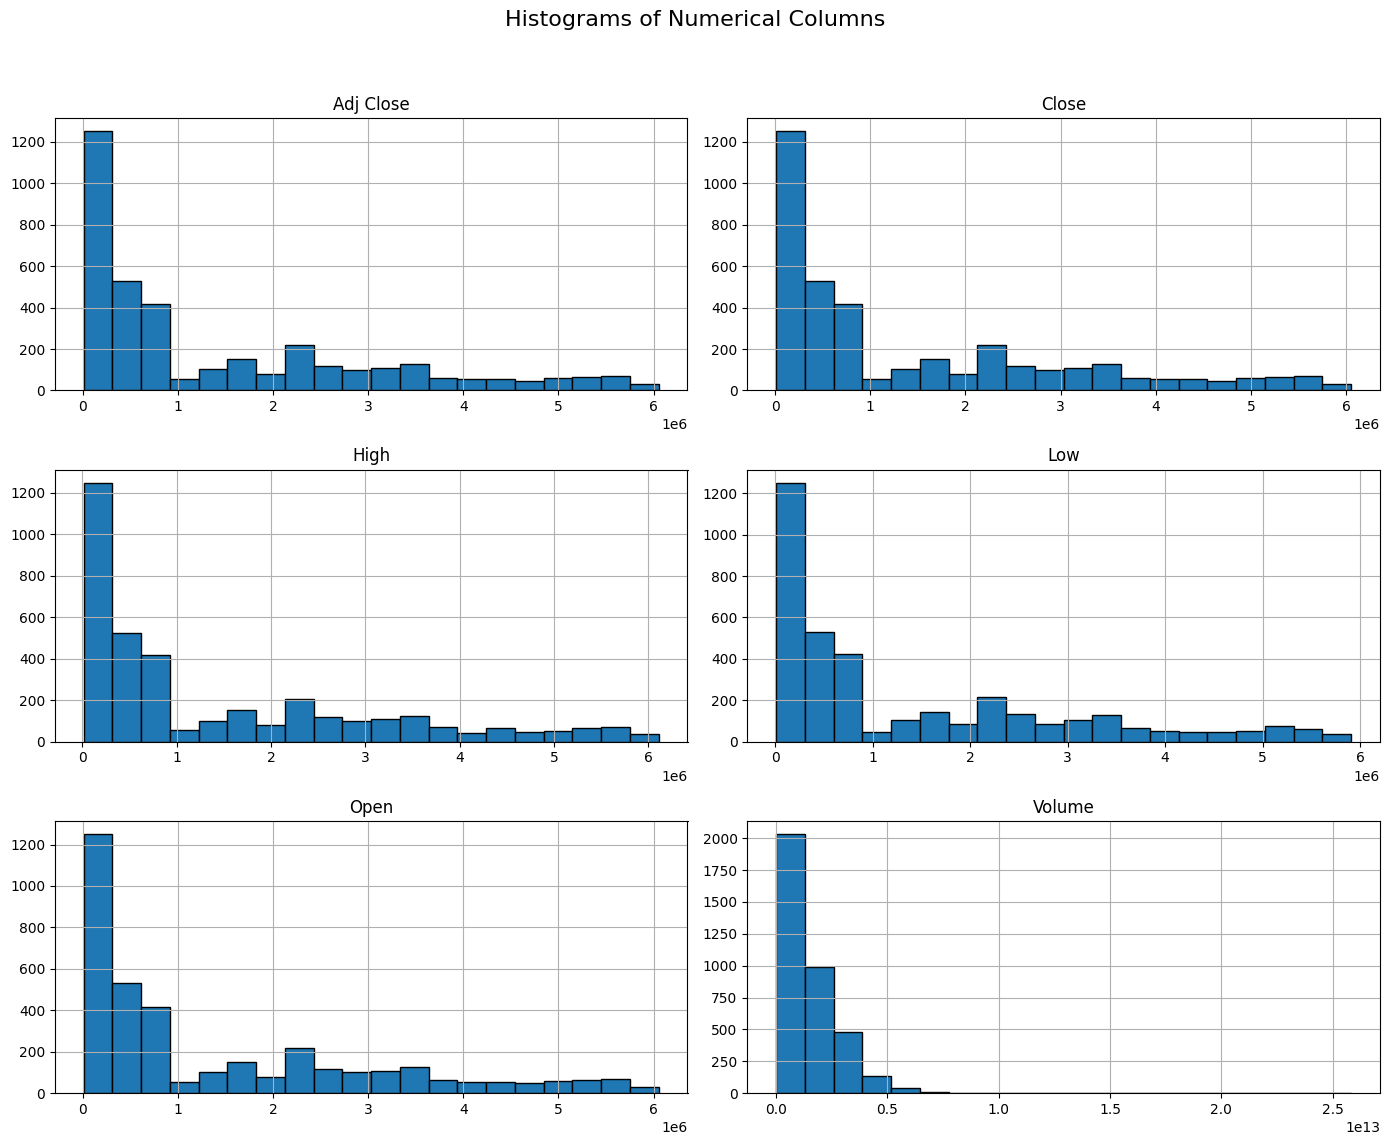

In [10]:
# Plotting histograms for all numerical columns
numerical_df.hist(figsize=(14, 12), bins=20, edgecolor='black')
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observation:**
- The histograms for Open, High, Low, Close, and Adj Close appear to be right-skewed. This indicates that a majority of the prices fall within a lower range, with a tail extending towards higher values.
- The right-skewed volume distribution means that while most days have low trading volumes, there are some days with very high trading volumes that are less common but notable. This pattern helps us understand that trading activity usually stays low, with occasional spikes.

### **Boxplot Construction**

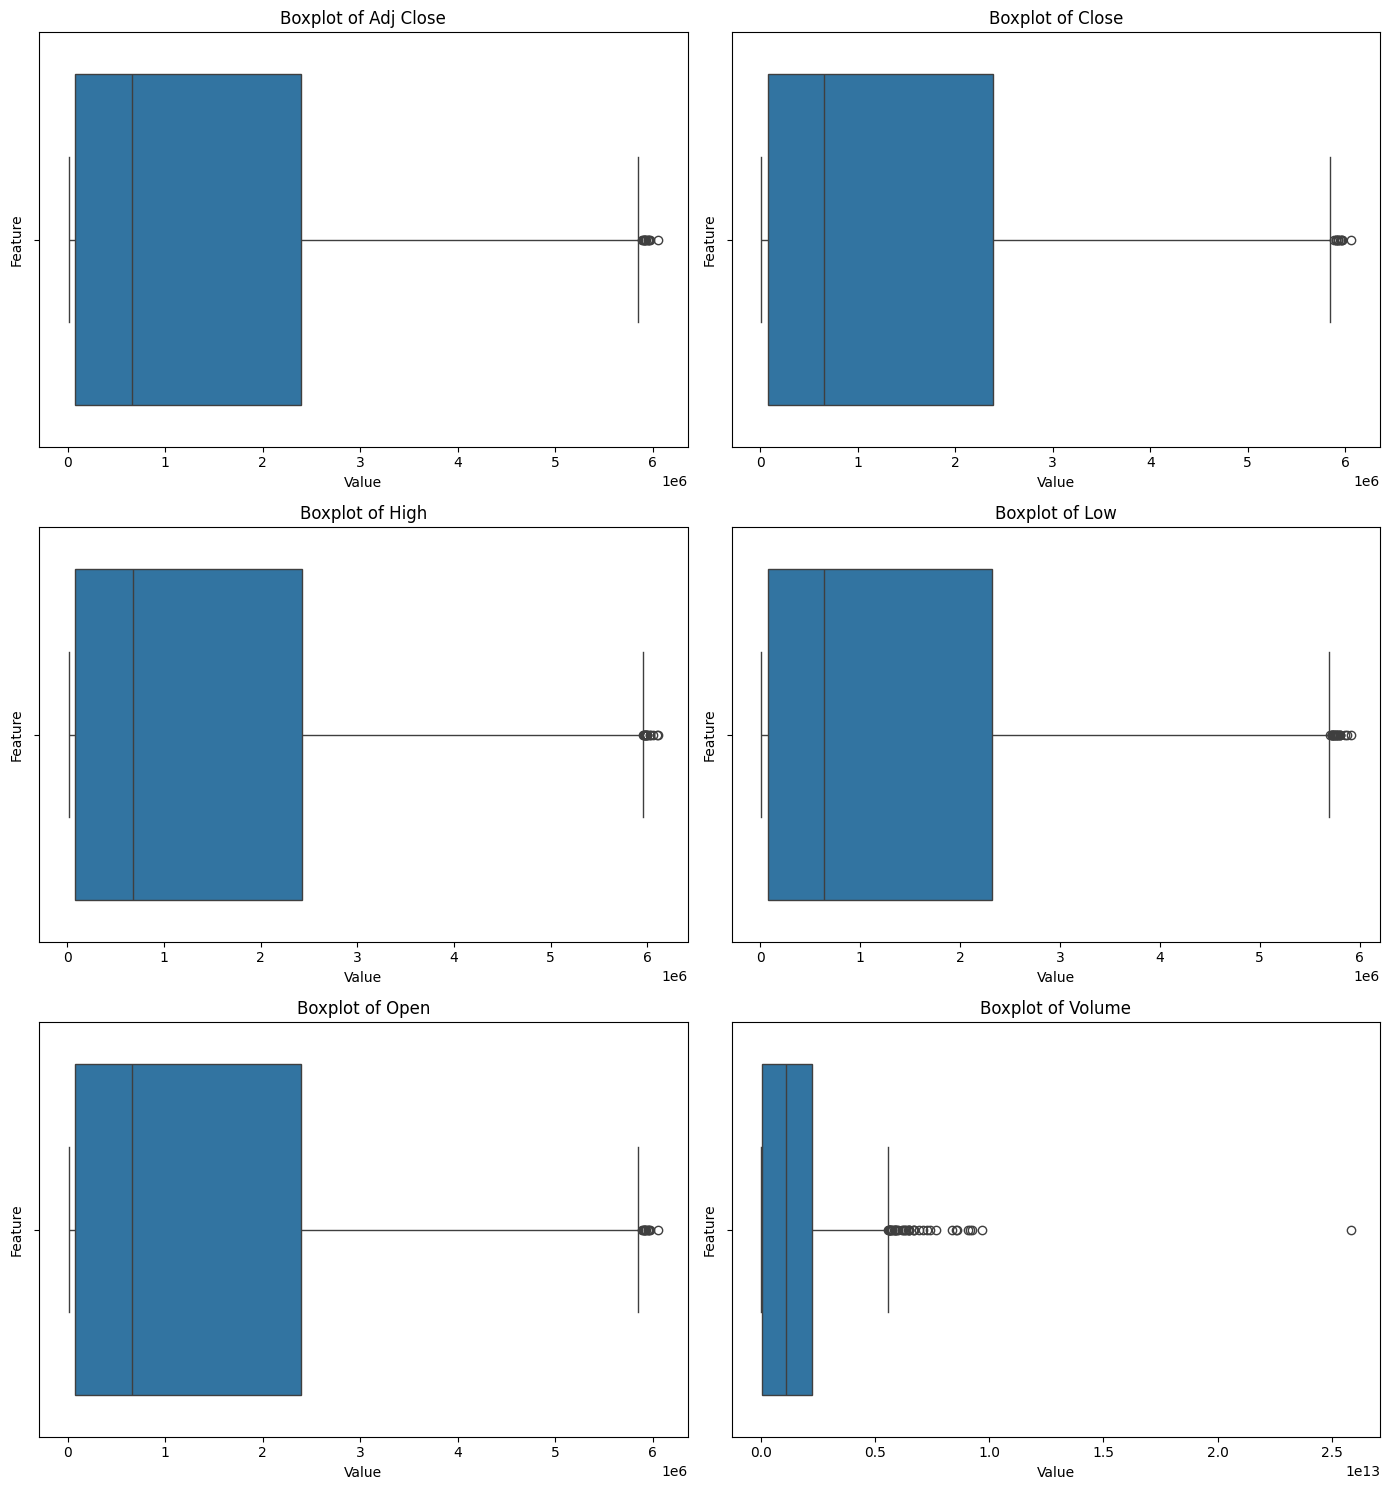

In [11]:
# Define the number of columns for the subplots
num_cols = 2

# Determine the number of rows needed
num_rows = (len(numerical_df.columns) + num_cols - 1) // num_cols

# Create subplots
plt.figure(figsize=(14, num_rows * 5))  # Adjust the figure size as needed

for i, column in enumerate(numerical_df.columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Create subplot for each column
    sns.boxplot(data=numerical_df[column], orient='h')
    plt.title(f'Boxplot of {column}')
    plt.xlabel('Value')
    plt.ylabel('Feature')
    #plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# **Data Visualization**

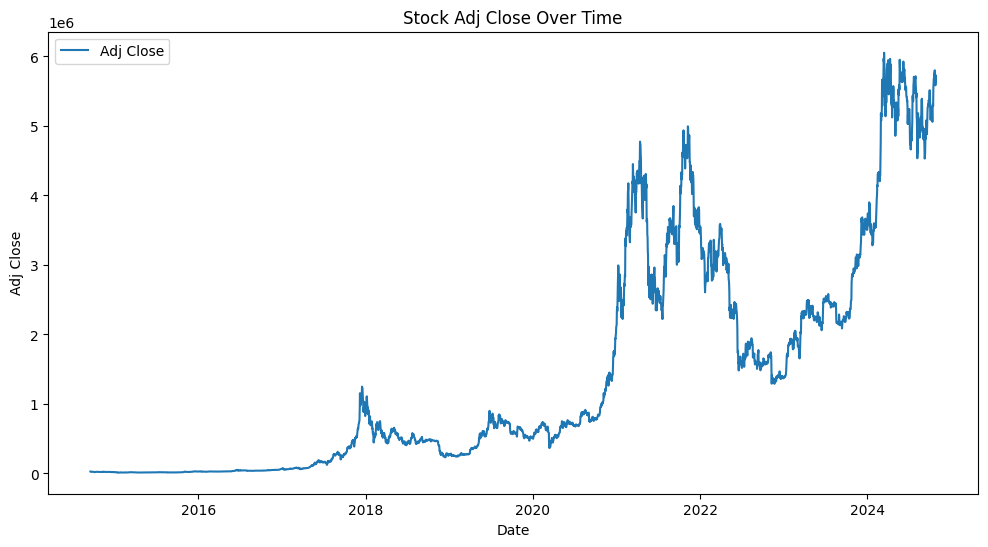

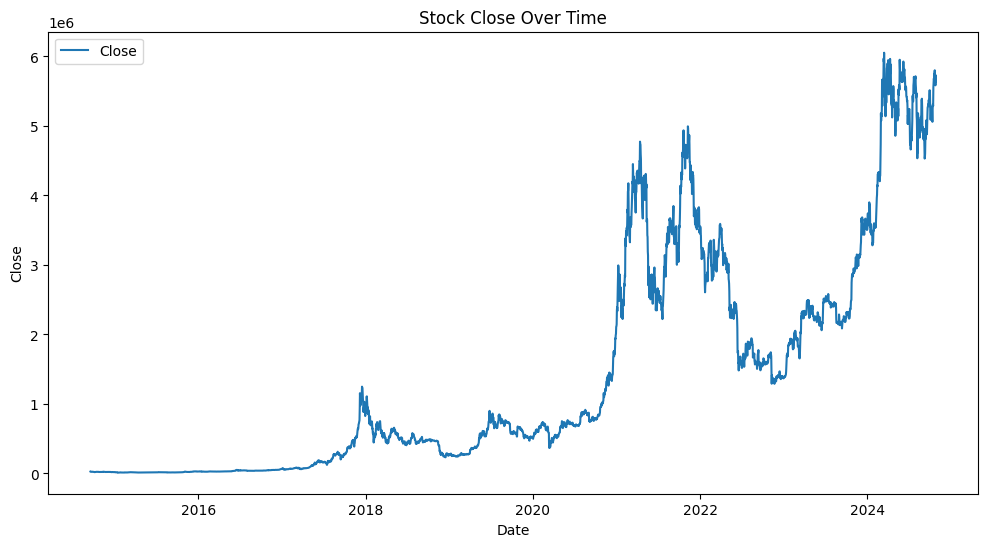

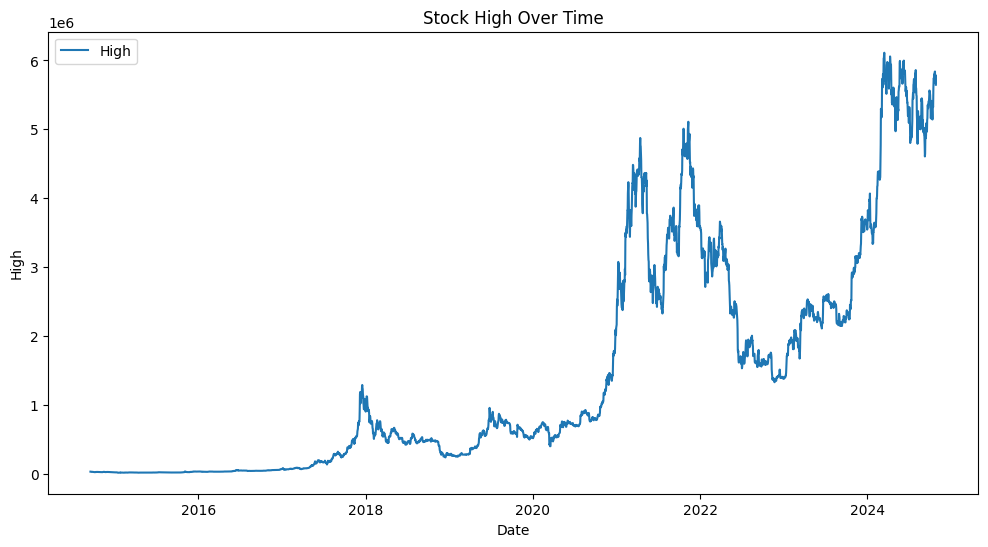

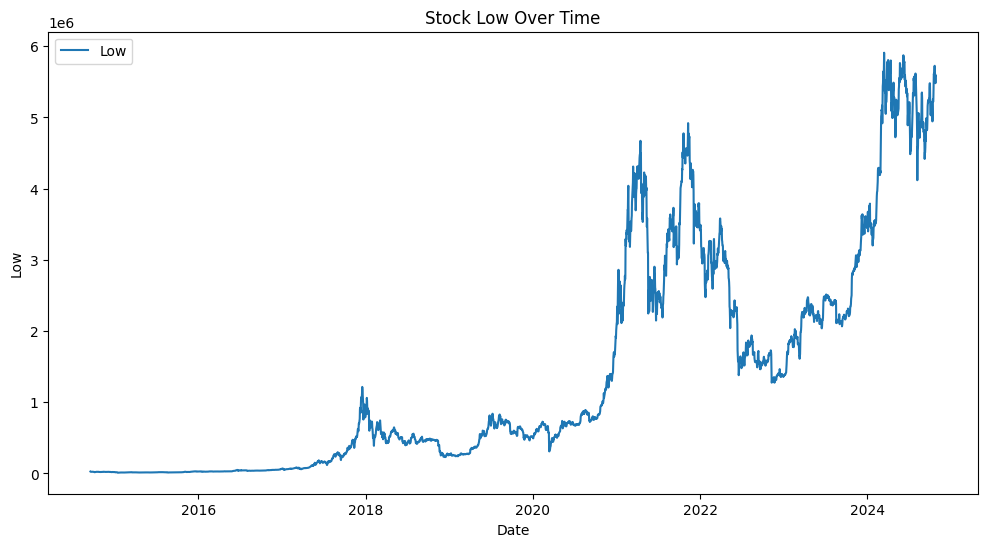

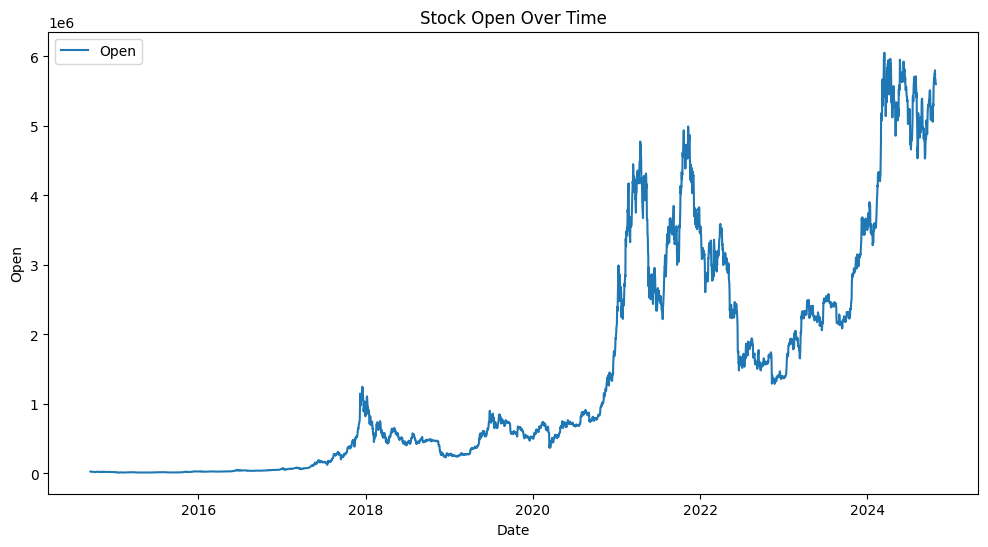

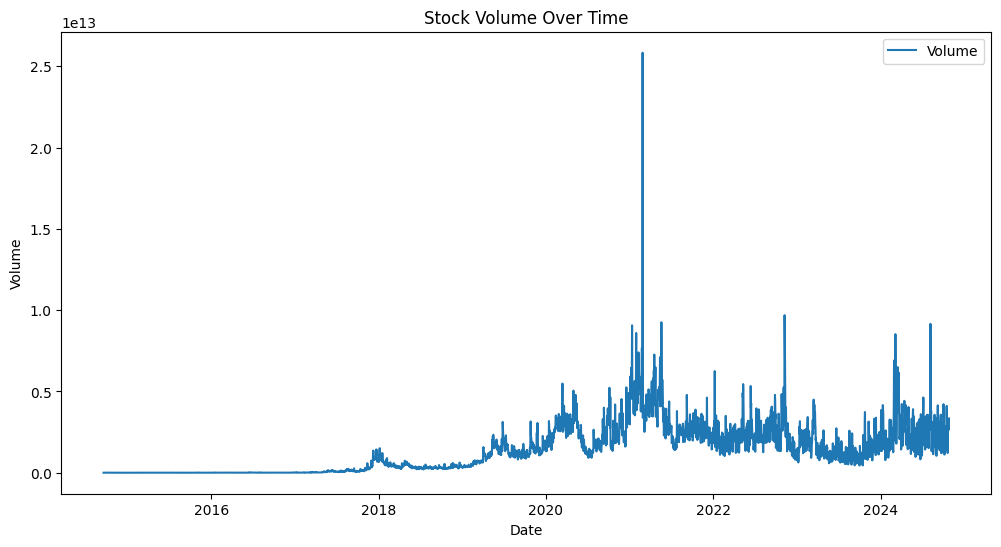

In [ ]:
for column in numerical_df:
    plt.figure(figsize=(12, 6))  # Create a new figure for each plot
    plt.plot(bitcoin_data.Date, bitcoin_data[column], label=column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'Stock {column} Over Time')
    plt.legend()
    plt.show()

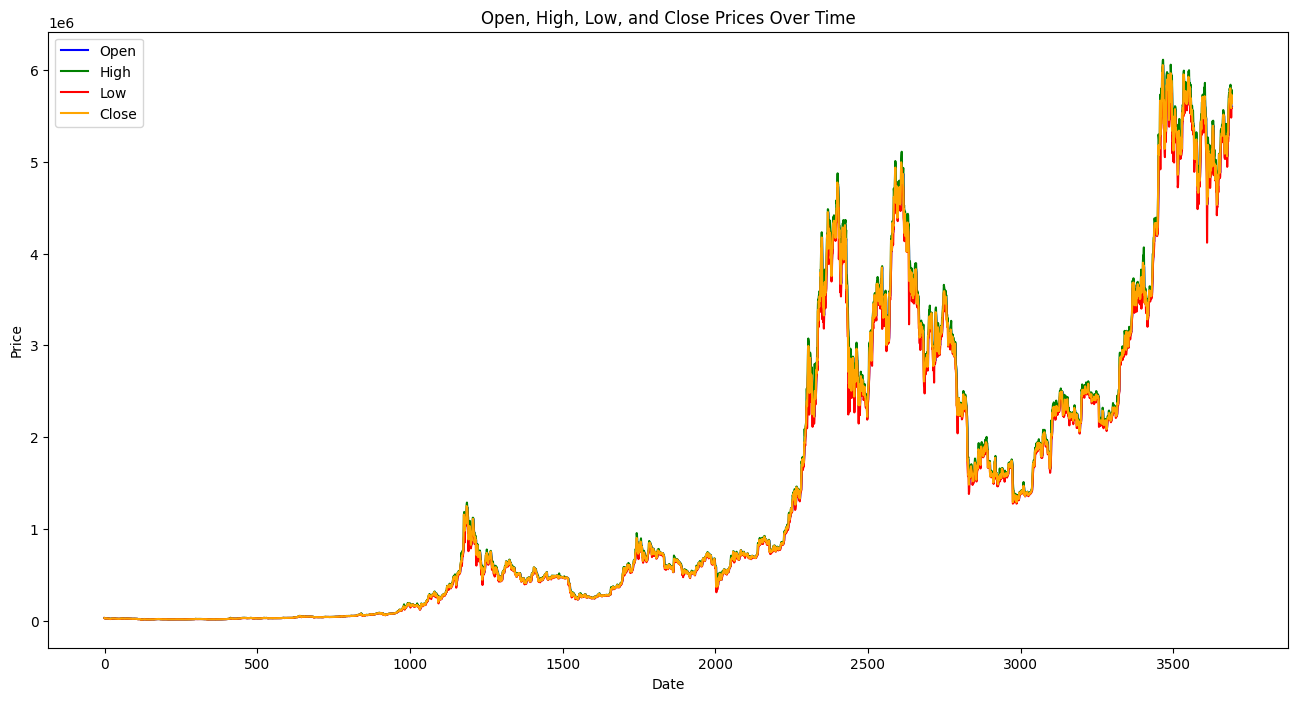

In [ ]:
# Plotting
plt.figure(figsize=(16, 8))
plt.plot(bitcoin_data.index, bitcoin_data['Open'], label='Open', color='blue')
plt.plot(bitcoin_data.index, bitcoin_data['High'], label='High', color='green')
plt.plot(bitcoin_data.index, bitcoin_data['Low'], label='Low', color='red')
plt.plot(bitcoin_data.index, bitcoin_data['Close'], label='Close', color='orange')

plt.title('Open, High, Low, and Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(False)
plt.show()

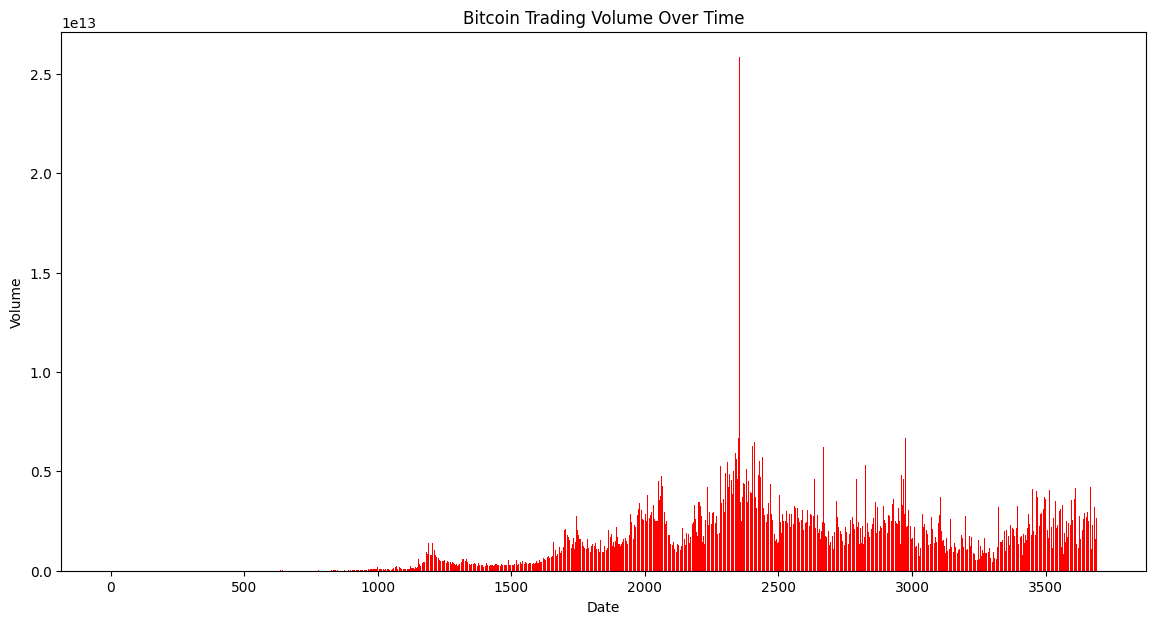

In [ ]:
plt.figure(figsize=(14, 7))
plt.bar(bitcoin_data.index, bitcoin_data['Volume'], color='red')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

## **Moving Averages**

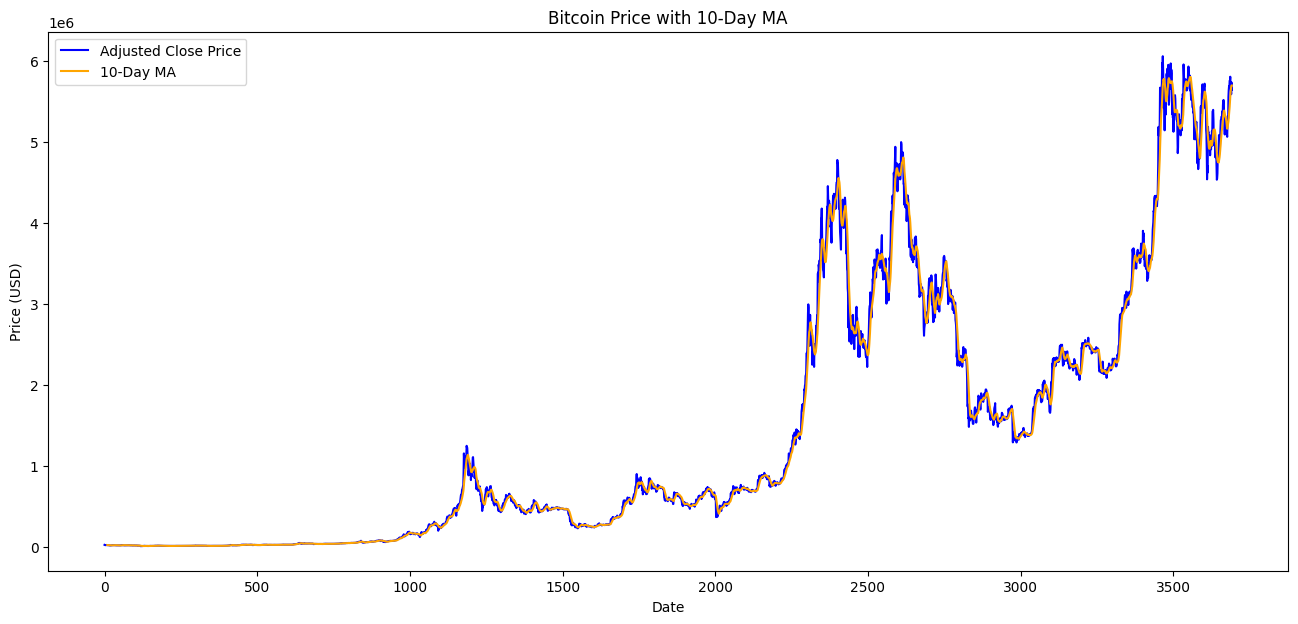

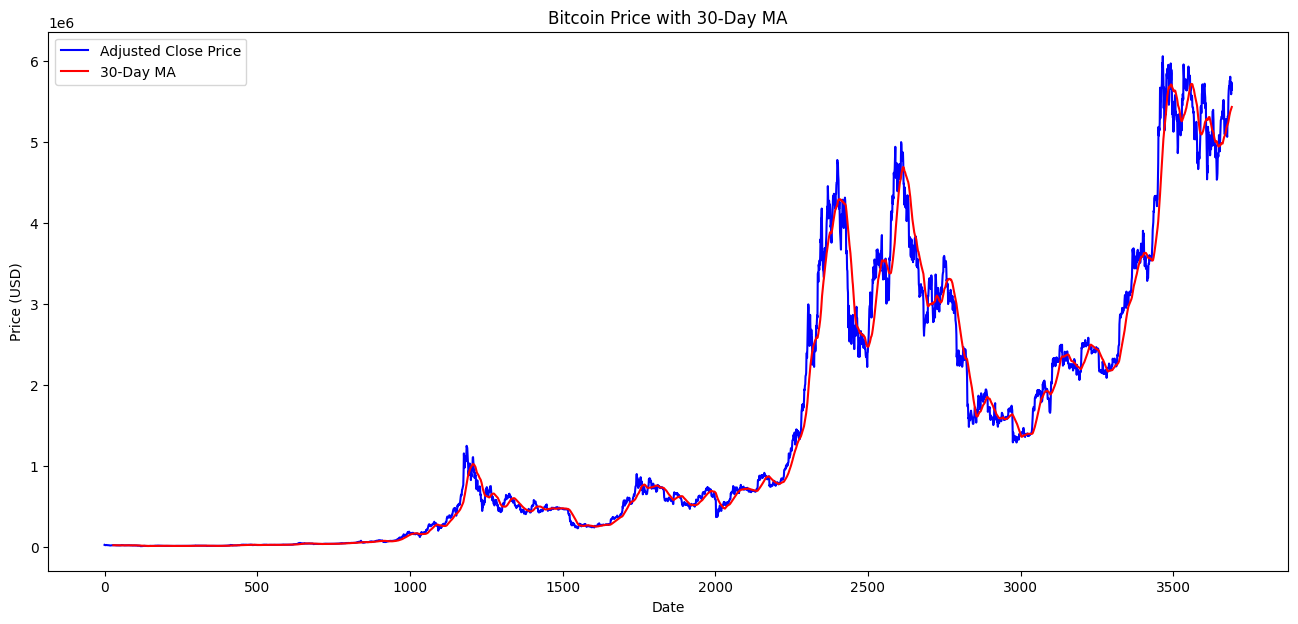

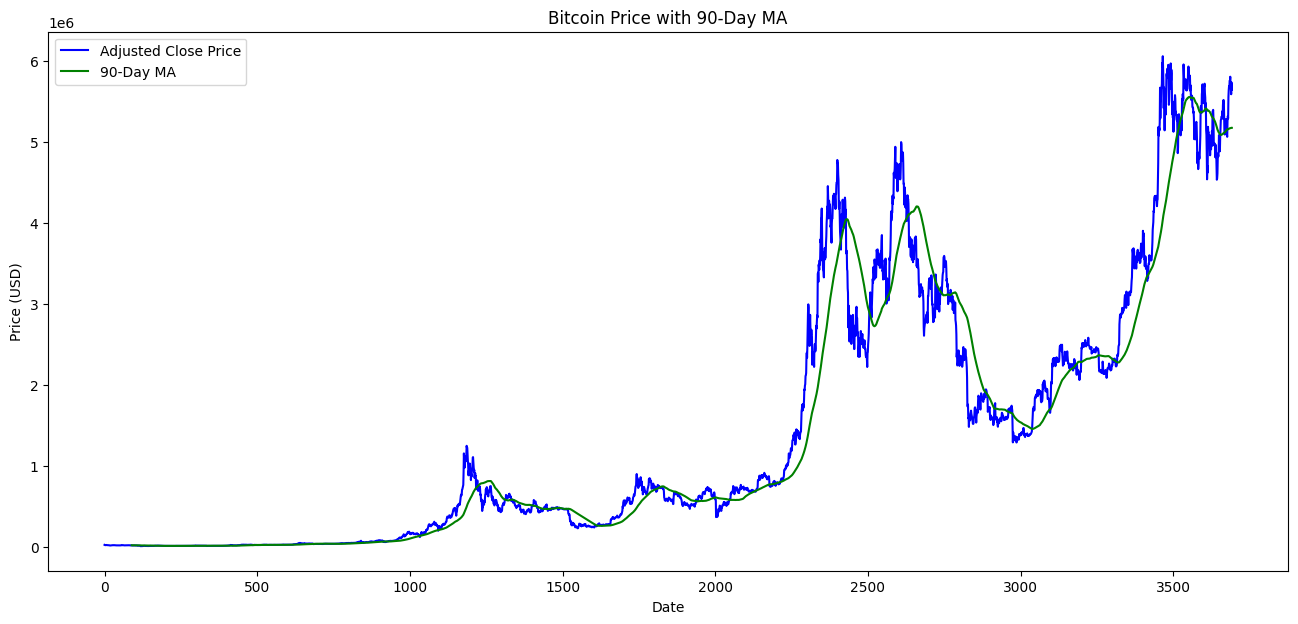

In [ ]:
import matplotlib.pyplot as plt

# Calculate moving averages
bitcoin_data['10_MA'] = bitcoin_data['Close'].rolling(window=10).mean()
bitcoin_data['30_MA'] = bitcoin_data['Close'].rolling(window=30).mean()
bitcoin_data['90_MA'] = bitcoin_data['Close'].rolling(window=90).mean()

# List of moving averages to plot
moving_averages = ['10_MA', '30_MA', '90_MA']
colors = ['orange', 'red', 'green']
labels = ['10-Day MA', '30-Day MA', '90-Day MA']

# Create separate graphs for each moving average
for ma, color, label in zip(moving_averages, colors, labels):
    plt.figure(figsize=(16, 7))
    plt.plot(bitcoin_data['Close'], label='Adjusted Close Price', color='blue')
    plt.plot(bitcoin_data[ma], label=label, color=color)
    plt.title(f'Bitcoin Price with {label}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

## **Daily Returns**

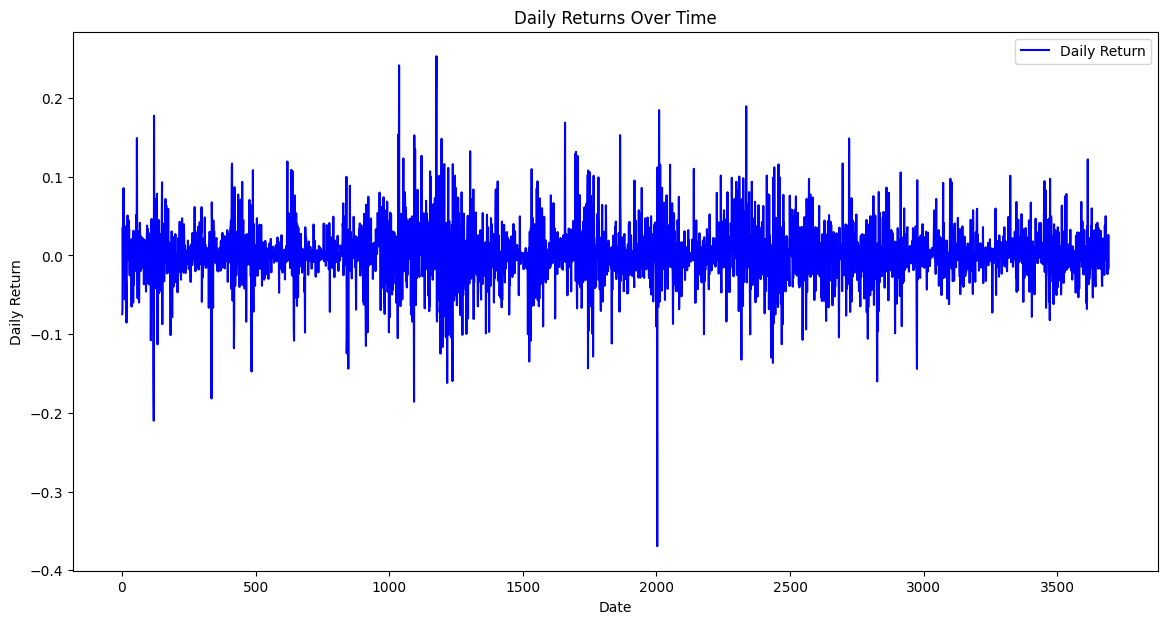

In [ ]:
bitcoin_data['Daily Returns'] = bitcoin_data['Close'].pct_change()

plt.figure(figsize=(14, 7))
plt.plot(bitcoin_data.index, bitcoin_data['Daily Returns'], label='Daily Return', color = 'blue')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(False)
plt.show()

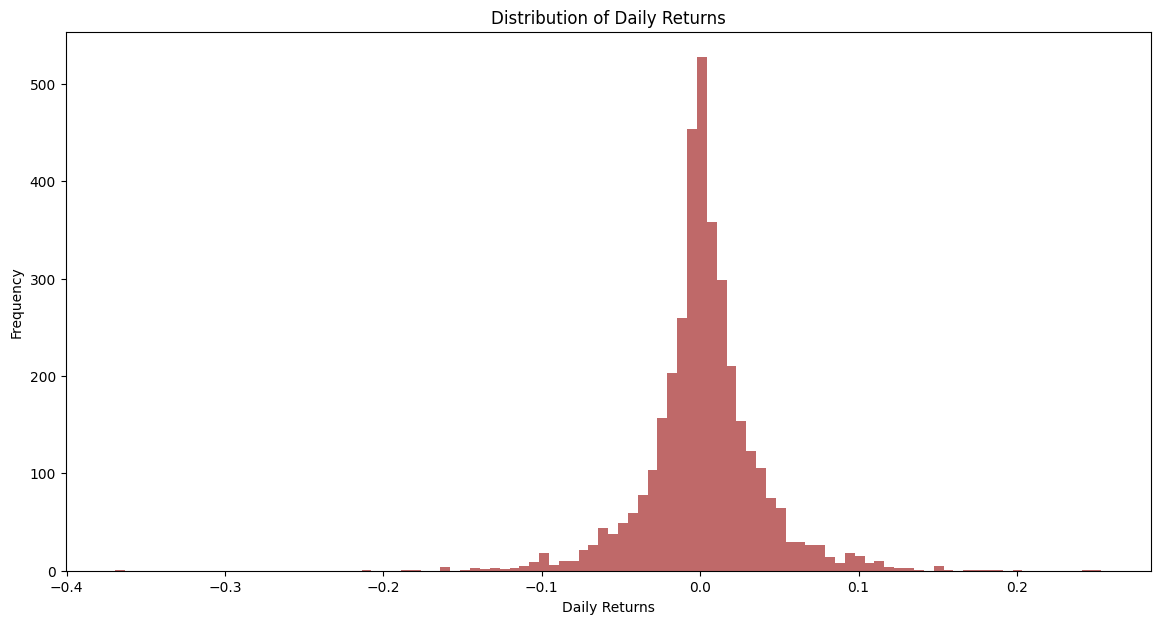

In [ ]:
plt.figure(figsize=(14, 7))
plt.hist(bitcoin_data['Daily Returns'].dropna(), bins=100, color='brown', alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

## **Volatility**
Volatility in Bitcoin (BTC) refers to the degree of variation in its price over a specific period. It measures how much the price of Bitcoin fluctuates, providing insights into the asset's risk and potential for price movements.

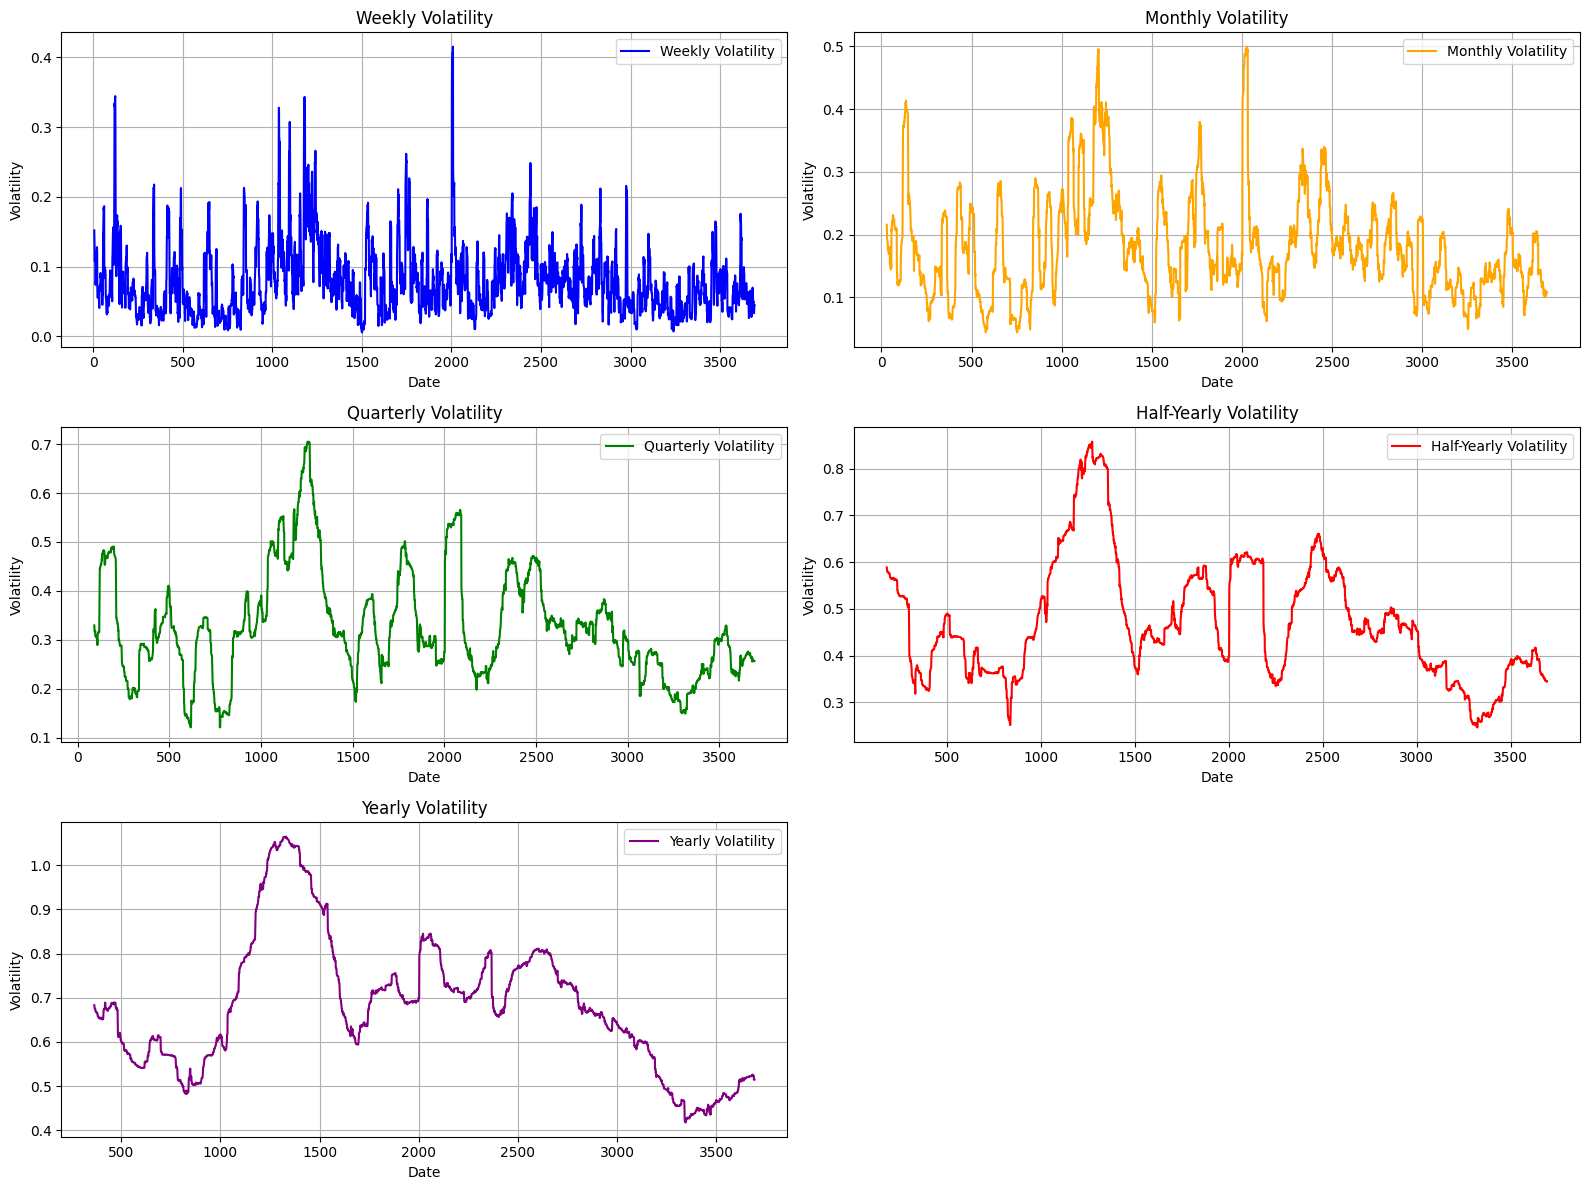

In [ ]:
# Calculate daily returns
bitcoin_data['Daily Returns'] = bitcoin_data['Close'].pct_change()

# Function to calculate rolling volatility
def calculate_volatility(df, window_size):
    return df['Daily Returns'].rolling(window=window_size).std() * np.sqrt(window_size)

# Calculate volatility for different periods
bitcoin_data['Weekly Volatility'] = calculate_volatility(bitcoin_data, 7)   # 7 days for weekly
bitcoin_data['Monthly Volatility'] = calculate_volatility(bitcoin_data, 30)  # ~30 days for monthly
bitcoin_data['Quarterly Volatility'] = calculate_volatility(bitcoin_data, 90)  # ~90 days for quarterly
bitcoin_data['Half-Yearly Volatility'] = calculate_volatility(bitcoin_data, 182)  # ~182 days for half-yearly
bitcoin_data['Yearly Volatility'] = calculate_volatility(bitcoin_data, 365)  # ~365 days for yearly

# Plotting the volatilities
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(bitcoin_data['Weekly Volatility'], label='Weekly Volatility', color='blue')
plt.title('Weekly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()

plt.subplot(3, 2, 2)
plt.plot(bitcoin_data['Monthly Volatility'], label='Monthly Volatility', color='orange')
plt.title('Monthly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()

plt.subplot(3, 2, 3)
plt.plot(bitcoin_data['Quarterly Volatility'], label='Quarterly Volatility', color='green')
plt.title('Quarterly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()

plt.subplot(3, 2, 4)
plt.plot(bitcoin_data['Half-Yearly Volatility'], label='Half-Yearly Volatility', color='red')
plt.title('Half-Yearly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()

plt.subplot(3, 2, 5)
plt.plot(bitcoin_data['Yearly Volatility'], label='Yearly Volatility', color='purple')
plt.title('Yearly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Volatility Percentage**

In [ ]:
import numpy as np

# Calculate daily returns
bitcoin_data['Daily Returns'] = bitcoin_data['Close'].pct_change()

# Calculate daily volatility (standard deviation of daily returns)
daily_volatility = np.std(bitcoin_data['Daily Returns'].dropna())

# Weekly volatility (assuming 7 days in a week)
weekly_volatility = daily_volatility * np.sqrt(7)

# Monthly volatility (assuming approximately 30 days in a month)
monthly_volatility = daily_volatility * np.sqrt(30)

# Quarterly volatility (assuming approximately 90 days in a quarter)
quarterly_volatility = daily_volatility * np.sqrt(90)

# Half-yearly volatility (assuming approximately 182 days in half a year)
half_yearly_volatility = daily_volatility * np.sqrt(182)

# Annualized volatility (assuming approximately 365 days in a year)
annualized_volatility = daily_volatility * np.sqrt(365)

# Convert to percentages
daily_volatility_percentage = daily_volatility * 100
weekly_volatility_percentage = weekly_volatility * 100
monthly_volatility_percentage = monthly_volatility * 100
quarterly_volatility_percentage = quarterly_volatility * 100
half_yearly_volatility_percentage = half_yearly_volatility * 100
annualized_volatility_percentage = annualized_volatility * 100

# Print results in percentage format
print(f"Daily Volatility: {daily_volatility_percentage:.2f}%")
print(f"Weekly Volatility: {weekly_volatility_percentage:.2f}%")
print(f"Monthly Volatility: {monthly_volatility_percentage:.2f}%")
print(f"Quarterly Volatility: {quarterly_volatility_percentage:.2f}%")
print(f"Half-Yearly Volatility: {half_yearly_volatility_percentage:.2f}%")
print(f"Annual Volatility: {annualized_volatility_percentage:.2f}%")

Daily Volatility: 3.63%
Weekly Volatility: 9.59%
Monthly Volatility: 19.86%
Quarterly Volatility: 34.39%
Half-Yearly Volatility: 48.91%
Annual Volatility: 69.26%


**Observation** : Bitcoin exhibits high volatility, with daily price changes averaging **3.63%**. This increases significantly over longer periods, reaching **9.59%** weekly, **19.86%** monthly, **34.39%** quarterly, and **69.26%** annually. Such fluctuations indicate that Bitcoin can provide opportunities for quick profits, especially for traders, but it also carries substantial risks for long-term investors.

##         

In [ ]:
df = bitcoin_data[['Date', 'Close']]
df

,Date,Close
0,2014-09-17,27851.64
1,2014-09-18,25774.12
2,2014-09-19,24023.34
3,2014-09-20,24881.81
4,2014-09-21,24268.26
...,...,...
3688,2024-10-22,5663915.00
3689,2024-10-23,5664384.00
3690,2024-10-24,5584820.00
3691,2024-10-25,5731121.00


In [ ]:
# Preprocessing: Convert 'Date' to datetime and set as index
# df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)
df

,Close
Date,
2014-09-17,27851.64
2014-09-18,25774.12
2014-09-19,24023.34
2014-09-20,24881.81
2014-09-21,24268.26
...,...
2024-10-22,5663915.00
2024-10-23,5664384.00
2024-10-24,5584820.00


#         

# **Model Building**

# **Long Short-Term Memory**

Long Short-Term Memory, commonly known as LSTM, is a type of recurrent neural network (RNN) architecture designed to handle sequential data. Unlike traditional RNNs, LSTMs can capture long-range dependencies and retain information over extended periods, making them particularly effective for tasks such as time series prediction, natural language processing, and speech recognition.

The key features of LSTMs are:

1. **Cell State**: LSTMs maintain a cell state that carries information across time steps, allowing them to remember or forget information as needed.

2. **Gates**: They use three gates—input, forget, and output gates—to control the flow of information:
   - **Input Gate**: Decides what information to add to the cell state.
   - **Forget Gate**: Determines what information to discard from the cell state.
   - **Output Gate**: Controls what information from the cell state is output to the next layer or as the final output.

This architecture enables LSTMs to learn from sequences of data more effectively than standard RNNs, making them popular in various applications, from language translation to stock price forecasting.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Select the 'Close' price column
data = df['Close'].values.reshape(-1, 1)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data

array([[0.0027791 ],
       [0.00243529],
       [0.00214556],
       ...,
       [0.922398  ],
       [0.94660926],
       [0.93136198]])

## **Data Partition (80:20)**

In [ ]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[0:train_size]
test_data = data[train_size:len(data)]

print(f"Training Data Size: {len(train_data)}")
print(f"Testing Data Size: {len(test_data)}")

Training Data Size: 2954
Testing Data Size: 739


### **Preparing the data for LSTM**

In [ ]:
# Function to prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

## **Hyperparameter Tuning**

In [ ]:
# Hyperparameter ranges
look_back_values = [5, 10, 20, 30]  # Number of previous time steps to consider
units_values = [25, 50, 100, 150]   # Number of units in the hidden layer
layer_values = [1, 2]               # Number of layers in the model

best_rmse = float('inf')
best_look_back = None
best_units = None
best_layers = None
best_model = None

for look_back in look_back_values:
    for units in units_values:
        for layers in layer_values:
            print(f"\nTraining with look_back={look_back}, units={units}, layers={layers}")

            # Create the training and testing datasets
            X_train, Y_train = create_dataset(train_data, look_back)
            X_test, Y_test = create_dataset(test_data, look_back)

            # Reshape the input to be [samples, time steps, features] which is required for LSTM
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

            # Create a multi-layer LSTM model
            model_lstm = Sequential()
            for _ in range(layers):
                model_lstm.add(LSTM(units=units, return_sequences=True if _ < layers - 1 else False, input_shape=(X_train.shape[1], 1)))
            model_lstm.add(Dense(1))

            # Compile the model
            model_lstm.compile(loss='mean_squared_error', optimizer='adam')

            # Train the model
            model_lstm.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

            # Make predictions
            train_predict = model_lstm.predict(X_train)
            test_predict = model_lstm.predict(X_test)

            # Invert predictions back to original scale
            train_predict = scaler.inverse_transform(train_predict)
            Y_train = scaler.inverse_transform([Y_train])
            test_predict = scaler.inverse_transform(test_predict)
            Y_test = scaler.inverse_transform([Y_test])

            # Evaluate the model
            train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
            test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))

            print(f"Train Root Mean Squared Error: {train_rmse}")
            print(f"Test Root Mean Squared Error: {test_rmse}")

            # Check if this is the best model so far
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_look_back = look_back
                best_units = units
                best_layers = layers
                best_model = model_lstm

print(f"Best look_back: {best_look_back}")
print(f"Best units: {best_units}")
print(f"Best layers: {best_layers}")
print(f"Best Test RMSE: {best_rmse}")

Streaming output truncated to the last 5000 lines.
Epoch 77/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1682e-04
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3286e-04
Epoch 79/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2355e-04
Epoch 80/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0128e-04
Epoch 81/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0180e-04
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2186e-04
Epoch 83/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1533e-04
Epoch 84/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1566e-04
Epoch 85/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1362e-04
Epoch 86/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1257e-04
Epoch 87/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1470e-04
Epoch 88/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0923e-04
Epoch 89/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2903e-04
Epoch 90/100
93/93 ━━━━━━━

In [ ]:
print(f"Best Look Back: {best_look_back}")
print(f"Best Units: {best_units}")
print(f"Best Layers: {best_layers}")
print(f"Best Test RMSE: {best_rmse}")

Best Look Back: 10
Best Units: 25
Best Layers: 1
Best Test RMSE: 99271.76606106336


## **Prediction plot for test set**

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


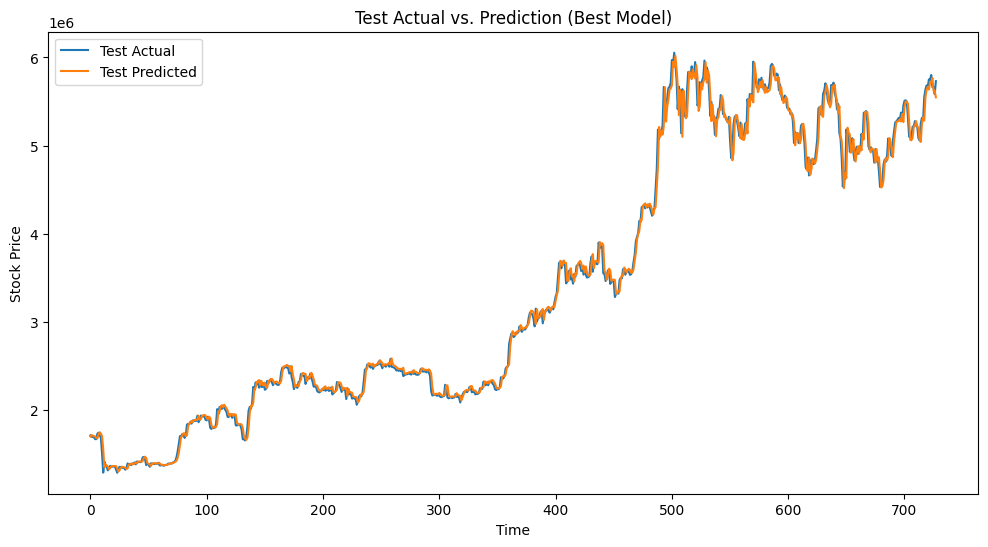

In [ ]:
# Optional: Plot the results for the best model
X_best_test, Y_best_test = create_dataset(test_data, best_look_back)
X_best_test = np.reshape(X_best_test, (X_best_test.shape[0], X_best_test.shape[1], 1))
best_test_predict = best_model.predict(X_best_test)
best_test_predict = scaler.inverse_transform(best_test_predict)
Y_best_test = scaler.inverse_transform([Y_best_test])

plt.figure(figsize=(12, 6))
plt.plot(Y_best_test[0], label='Test Actual')
plt.plot(best_test_predict[:,0], label='Test Predicted')
plt.title('Test Actual vs. Prediction (Best Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## **Saving the model**

In [ ]:
from tensorflow.keras.models import save_model

# Save the best model
model_filename = f'LSTM_Bitcoin_{best_look_back}_{best_layers}({best_rmse.round(2)}).h5'
save_model(model_lstm, model_filename)

print(f"The best model is saved as {model_filename}")

The best model is saved as LSTM_Bitcoin_10_1(99271.77).h5
